In [6]:
import sys
link="/Users/xinyuexu/Public/multi_strategy/code/FOF_in_chinese_market/PYMC/pymc"
sys.path.append(link)
import pymc as pm
import pytensor
import pytensor.tensor as at
import arviz as az
import matplotlib.pyplot as plt
#import numpy as np
import pandas as pd

import pymc.sampling.jax
import seaborn as sns
import numpy as np

In [7]:
import sys
link="/Users/xinyuexu/Public/multi_strategy/code/FOF_in_chinese_market/PYMC/pymc"
sys.path.append(link)
import pymc as pm
import pytensor
import pytensor.tensor as at
import arviz as az
import matplotlib.pyplot as plt
#import numpy as np
import pandas as pd

import pymc.sampling.jax
import seaborn as sns

cm=sns.color_palette("Spectral", as_cmap=True)
#cm = sns.light_palette("Spectral", as_cmap=True)
import matplotlib.pyplot as plt
plt.style.use("bmh")
font = ['Songti SC']
parameters = {'xtick.labelsize': 15,
          'ytick.labelsize': 15,
          "font.family" : "sans-serif",
          "font.sans-serif":font,
          'font.size':15,
          "axes.unicode_minus":False}
plt.rcParams.update(parameters)

# 数据加载：宏观、指数、alpha的数据

In [8]:
import pickle
f2 = open('temp.pkl', 'rb')  
macro_data = pickle.load(f2)  
macro_zscore = pickle.load(f2)  
index_orig = pickle.load(f2)  
index_transformer = pickle.load(f2)  
df_fund = pickle.load(f2)  
df_fund.index=df_fund.index.to_period("M")
f2.close() 

df_ret_ratio=index_orig

model_begin_date="2012-09-01"

index_transformer_month= index_transformer.resample("M").sum()



df_data = pd.DataFrame(columns = ["Period"]).set_index("Period")
date_model =pd.date_range(start=model_begin_date,end="2022-09-01",freq="M").to_period("M")
df_data.index=date_model
df_data["Test_"] = "True"



df_macro_filter = pd.concat([df_data,macro_zscore.shift(3)],axis=1).query('Test_=="True"')
df_macro_filter_predict = pd.concat([df_data,macro_zscore],axis=1).query('Test_=="True"')

df_Factor_filter=pd.concat([df_data,index_transformer_month],axis=1).query('Test_=="True"')
data_alpha_filter =pd.concat([df_data,df_fund],axis=1).query('Test_=="True"')
data_alpha_filter= data_alpha_filter.dropna(axis=1)

data_total =pd.concat([df_Factor_filter.drop("Test_",axis=1),data_alpha_filter.drop("Test_",axis=1)],axis=1).T


Df_macro = df_macro_filter.drop("Test_",axis=1).T
Df_macro_predict = df_macro_filter_predict.drop("Test_",axis=1).T


Df_Factor=(df_Factor_filter.drop("Test_",axis=1).T)*12
Df_alpha=(data_alpha_filter.drop("Test_",axis=1).T)*12





# 数据加载:先验信息

In [9]:
import pickle
f3 = open('temp_model1218.pkl', 'rb')  
Df_macro = pickle.load(f3)  
Df_model_example = pickle.load(f3)  
Df_macro_predict = pickle.load(f3)  
Df_Factor = pickle.load(f3)  
Df_alpha = pickle.load(f3)  
df_sharpe = pickle.load(f3)  
data_total=pickle.load(f3)
prior_mu=pickle.load(f3)
prior_std=pickle.load(f3)
f3.close() 



import pandas as pd
macro_dim =Df_model_example.shape[0]
fund_dim= Df_Factor.shape[0]
model_dim =data_total.shape[0]
date_model =pd.date_range(start="2012-09-01",end="2022-09-01",freq="M").to_period("M")


model_dim_T=date_model.shape[0]
alpha_mean__prior =0.36
alpha_std__prior =0.17
LKJ_eta__prior =3
LKJ_st__prior =1.0
LKJ_st_prior =1.0
T_len=model_dim_T
__Df_alpha_model=Df_alpha
alpha_len = __Df_alpha_model.shape[0]




fund_dim= Df_Factor.shape[0]
model_dim =data_total.shape[0]
model_dim_T=date_model.shape[0]
coords_test = {"Fund": Df_Factor.index.values, "date":data_total.columns.to_timestamp().astype("int"),"macro":Df_model_example.index.values,"Alpha":__Df_alpha_model.index.values}


# 跑单模型调整系数

In [36]:


# eta_prior = 4
# delta_prior = 5

In [92]:
# for i in Df_macro.index[[1]]:
#     print(i)



In [99]:
import arviz as az

for i in Df_macro.index[[1]]:

    model_name = "model_total_"+i
    result_name = "trace_alpha_total_"+i
    Df_model_example = Df_macro.loc[[i]]
    
    macro_dim =Df_model_example.shape[0]
    s="""with pm.Model(coords=coords_test) as {}:
        macro_data = pm.Data("宏观因子", Df_model_example.values.astype(float),mutable=True,dims=("macro","date"))
        sr_t = pm.MutableData(name="夏普抽样数据自回归项", value=df_sharpe.loc["2012-09":"2022-08"].T.values, dims=("Fund","date"))
       # --- prior ---#
        sharpe_ratio= pm.Normal("夏普比例先验", prior_mu.T, prior_std, dims=("Fund"))
        sharpe_ratio=at.reshape(sharpe_ratio,(fund_dim,1))

        beta = pm.Normal("宏观因子反应系数:指数及因子条件夏普SR", mu=0, sigma=1,shape=(fund_dim,macro_dim),dims=("Fund","macro"))


        macro_contribution = pm.Deterministic(
            name="宏观因子贡献",
            var=pm.math.dot(beta,macro_data),
            dims=("Fund","date"),
        )
        
        delta = pm.Beta(name="夏普样本数据预测系数:宏观因子贡献条件", alpha=1, beta=10)
  
        eta = pm.Gamma(name="夏普样本数据预测系数eta:夏普样本数据自回归项sr", alpha=0.5, beta=10)

        delta_eta = pm.Deterministic("夏普比例预测系数detla:条件夏普自回归项SR",1-delta-eta)
        # --- model parametrization ---
        pm.Potential(name="constrain", var=at.switch(eta > 1 - delta, -np.inf, 0))

       # --- damped dynamic mean--@
        sr0 = pm.MutableData(
            name="条件夏普SR自回归项", value=np.zeros((sr_t.shape.eval()[0],sr_t.shape.eval()[1])), dims=("Fund","date")
        )


        #sr0 = at.zeros((sr_t.shape.eval()[0],sr_t.shape.eval()[1]))
        sr0 = at.set_subtensor(sr0[:,0],sharpe_ratio[:,0])
        def one_step(macro_t,sr_tm1,SR_tm1,delta,eta):
            return delta*macro_t+eta*sr_tm1+(1-delta-eta)*SR_tm1


        outputs,_ = pytensor.scan(
            fn=one_step,
            sequences=[
                dict(input=(macro_contribution[:,1:].T),taps=[0]),
                dict(input=(sr_t.T),taps=[-1])
            ],
            outputs_info=dict(initial = (sr0.T),taps=[-1]),
            non_sequences=[delta,eta],
            strict=True,
        )



        sharpe_ratio_t = pm.Deterministic(
            name="条件夏普SR",var=at.set_subtensor(sr0[:,1:],outputs[:,0].T),dims=("Fund","date")
        )




        chol_factor, corr_chol_factor, stds_chol_factor = pm.LKJCholeskyCov("指数/风格基金的协方差矩阵分布", n=fund_dim, eta=LKJ_eta__prior, sd_dist=pm.HalfCauchy.dist(LKJ_st__prior), compute_corr=True)




        __stds_chol_factor =  at.reshape(stds_chol_factor,(fund_dim,1)) 
        __stds_chol_factor_T = at.tile(__stds_chol_factor,(1,T_len)) 

        T_n_cov =np.eye(T_len)

        factor_r= pm.Deterministic(name="指数及因子的收益率均值",var=sharpe_ratio_t*__stds_chol_factor_T,dims=("Fund","date"),)
        Factor_obs=pm.MatrixNormal('指数及因子的收益率实现', mu=factor_r, rowchol=chol_factor,colcov=T_n_cov,observed=Df_Factor,dims=("Fund","date"))



        ############################################
        ############################################
        ###############################################
        ############################################
        factor_loading = pm.Normal("主动基金的因子载荷", mu=0, sigma=2,shape=fund_dim,dims=("Fund"))
        factor_loading= at.reshape(factor_loading,(1,fund_dim))                       
        factor_contribution = pm.Deterministic(name="主动基金收益:因子暴露部分",var=pm.math.dot(factor_loading,factor_r))
        factor_contribution =at.reshape(factor_contribution,(1,T_len)) 
        factor_loading_sum_stack=at.tile(factor_contribution,(alpha_len,1))  
        
        chol, corr, stds = pm.LKJCholeskyCov("基金的协方差矩阵分布", n=alpha_len, eta=LKJ_eta__prior, sd_dist=pm.HalfCauchy.dist(LKJ_st__prior), compute_corr=True)
        __stds =  at.reshape(stds,(alpha_len,1)) 
        __stds_t = at.tile(__stds,(1,T_len)) 
        
        
        alpha = pm.Normal("主动基金纯粹阿尔法的共同先验",alpha_mean__prior, alpha_std__prior)
        alpha_n = pm.Normal("主动基金纯粹阿尔法的层次先验",alpha,sigma=1,shape=alpha_len,dims=("Alpha"))

  
        IC_alpha_t = pm.Deterministic("主动基金信息比例IC", alpha_n/stds,dims =("Alpha"))
        
        alpha_n= at.reshape(alpha_n,(alpha_len,1))

        
        
        fund_ret = pm.Deterministic("主动基金收益率均值:因子暴露与纯粹阿尔法",at.tile(alpha_n,(1,T_len)) + factor_loading_sum_stack,dims=("Alpha","date"))

  

        T_n_cov =np.eye(T_len)

        obs_sharpe=pm.MatrixNormal('主动基金的收益率实现', mu=fund_ret, rowchol=chol,colcov=T_n_cov,observed=__Df_alpha_model.values,dims=("Alpha","date"))


    """.format(model_name)
    exec(s)


    RANDOM_SEED = 8924
    h="""with {}:
        {} = pm.sample(target_accept=0.85, tune=500,draws=1000, chains=1,return_inferencedata = True,idata_kwargs = {{'log_likelihood': True}})
    """.format(model_name,result_name)
    exec(h)
    Df_macro_example_predict = Df_macro_predict.loc[[i]]
    e="""with {}:
        pm.set_data({{"宏观因子": Df_macro_example_predict.values.astype(float)}})
        {} = pm.sample_posterior_predictive(
            {},
        var_names=["条件夏普SR","指数及因子的收益率实现","主动基金的收益率实现"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )""".format(model_name,result_name,result_name)
    exec(e)
    
    #pp=az.InferenceData.from_zarr("yan.")
    # files="trace_{}.zarr".format(i)
    # save_="""trace_alpha_total_{}.to_zarr('{}')""".format(i,files)
    # exec(save_)

  

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc:Sequential sampling (1 chains in 1 job)
NUTS: [夏普比例先验, 宏观因子反应系数:指数及因子条件夏普SR, 夏普样本数据预测系数:宏观因子贡献条件, 夏普样本数据预测系数eta:夏普样本数据自回归项sr, 指数/风格基金的协方差矩阵分布, 主动基金的因子载荷, 基金的协方差矩阵分布, 主动基金纯粹阿尔法的共同先验, 主动基金纯粹阿尔法的层次先验]
INFO:pymc:NUTS: [夏普比例先验, 宏观因子反应系数:指数及因子条件夏普SR, 夏普样本数据预测系数:宏观因子贡献条件, 夏普样本数据预测系数eta:夏普样本数据自回归项sr, 指数/风格基金的协方差矩阵分布, 主动基金的因子载荷, 基金的协方差矩阵分布, 主动基金纯粹阿尔法的共同先验, 主动基金纯粹阿尔法的层次先验]


/Users/xinyuexu/opt/anaconda3/envs/FOF02/lib/python3.9/site-packages/pytensor/compile/function/types.py:972: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 2936 seconds.
INFO:pymc:Sampling 1 chain for 500 tune and 1_000 draw iterations (500 + 1_000 draws total) took 2936 seconds.
/Users/xinyuexu/opt/anaconda3/envs/FOF02/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (1000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
<string>:3: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
Sampling: [主动基金的收益率实现, 指数及因子的收益率实现]
INFO:pymc:Sampling: [主动基金的收益率实现, 指数及因子的收益率实现]


In [101]:
trace_alpha_total_dy


       delta = pm.Beta(name="夏普样本数据预测系数:宏观因子贡献条件", alpha=1, beta=10)
  
        eta = pm.Gamma(name="夏普样本数据预测系数eta:夏普样本数据自回归项sr", alpha=0.5, beta=10)


Inference data with groups:
	> posterior
	> predictions
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

In [105]:
az.summary(trace_alpha_total_dy,var_names=["夏普样本数据预测系数:宏观因子贡献条件"])


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
夏普样本数据预测系数:宏观因子贡献条件  0.007  0.004   0.002    0.014        0.0      0.0   

                     ess_bulk  ess_tail  r_hat  
夏普样本数据预测系数:宏观因子贡献条件     478.0     673.0    NaN

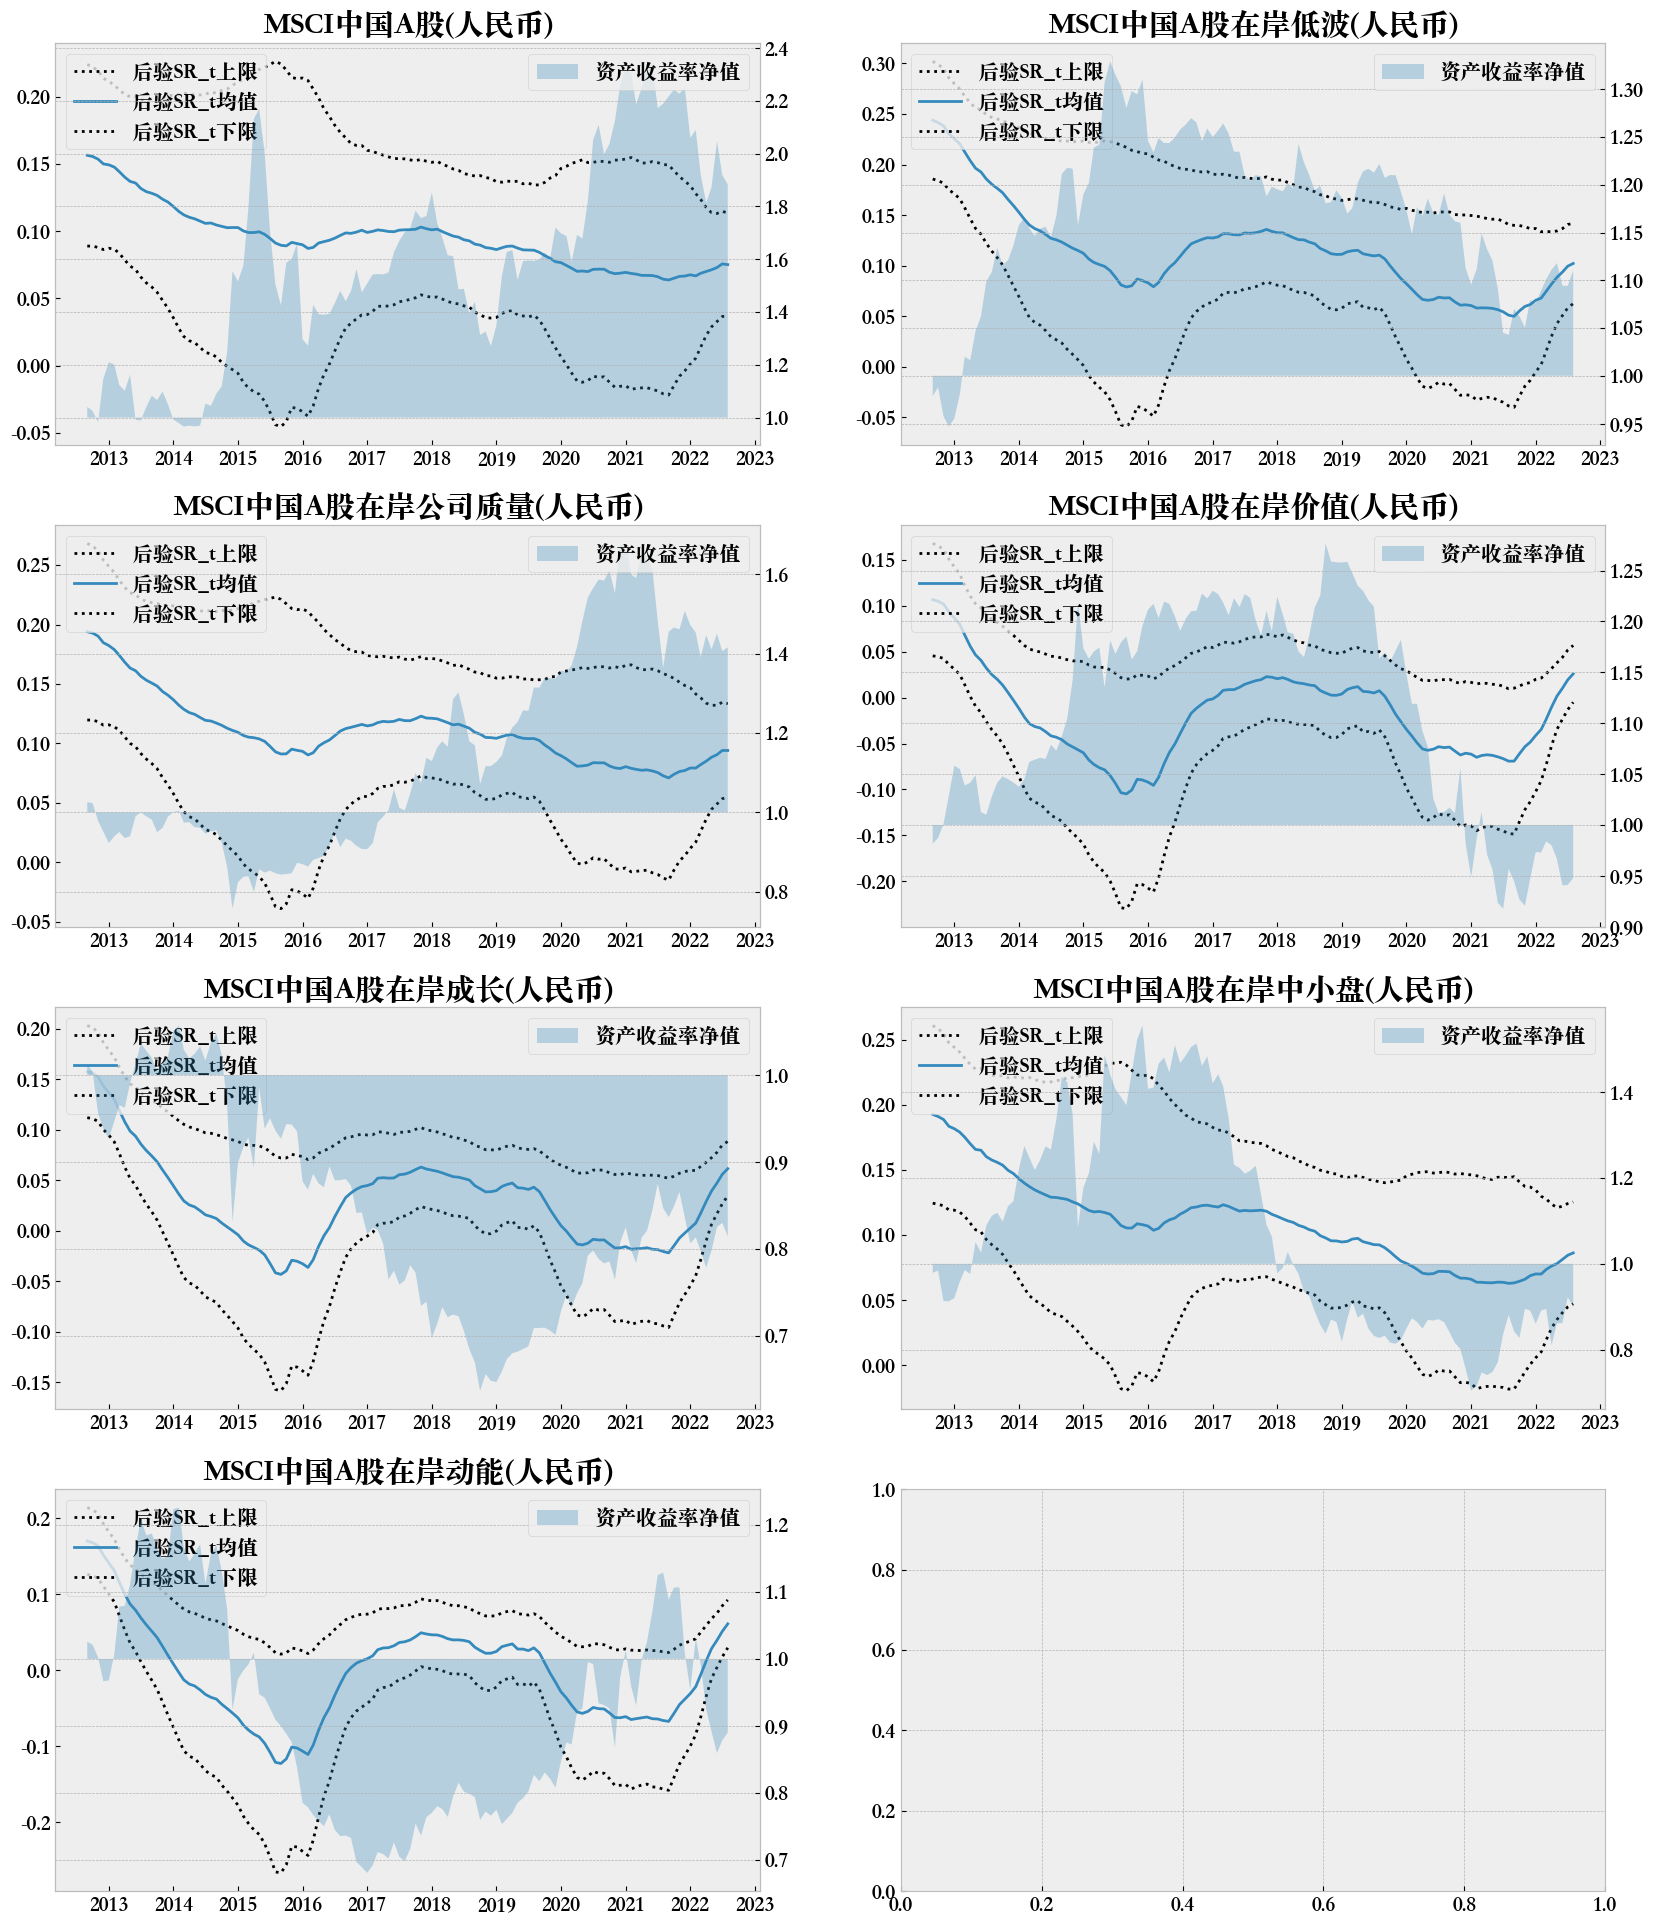

In [108]:
month_interval=3
fig,ax =plt.subplots(4,2,figsize=(20,4*6))
ax=ax.flatten()
SR_t_mean_fig=trace_alpha_total_dy.posterior.stack(pooled_chain=("chain", "draw"))["条件夏普SR"].mean(axis=2)
SR_t_std_fig=trace_alpha_total_dy.posterior.stack(pooled_chain=("chain", "draw"))["条件夏普SR"].std(axis=2)


data_fund=np.exp((Df_Factor/12).T.cumsum())
for i in range(fund_dim):
  
    
    #TT_figure= _xx+T_begin

    
    TT_figure_predict=(trace_alpha_total_dy.observed_data.date).astype('datetime64[ns]')+month_interval
    TT_figure=(trace_alpha_total_dy.observed_data.date).astype('datetime64[ns]')

    ax[i].plot(TT_figure,SR_t_mean_fig[i]+1*SR_t_std_fig[i],':',color="k",label="后验SR_t上限")
    ax[i].plot(TT_figure,SR_t_mean_fig[i],label="后验SR_t均值")
    ax[i].plot(TT_figure,SR_t_mean_fig[i]-1*SR_t_std_fig[i],':',color="k",label="后验SR_t下限")
    ax[i].set_title(Df_Factor.index.values[i])
    ax[i].legend(loc=2)
    ax[i].grid()
    
    
    ax_right = ax[i].twinx()
    
    #__drawdown =(draw_down_price[i] - draw_down_price[i+"_max"])/draw_down_price[i+"_max"]
    #print(__drawdown)
    ax_right.fill_between(TT_figure,data_fund[Df_Factor.index.values[i]],1,alpha=0.3,label="资产收益率净值")
    ax_right.legend(loc=1)

# 跑模型（多模型）及trace数据保存

In [ ]:
import arviz as az

for i in Df_macro.index:
    print(i)
    model_name = "model_total_"+i
    result_name = "trace_alpha_total_"+i
    Df_model_example = Df_macro.loc[[i]]
    
    macro_dim =Df_model_example.shape[0]
    s="""with pm.Model(coords=coords_test) as {}:
        macro_data = pm.Data("宏观因子", Df_model_example.values.astype(float),mutable=True,dims=("macro","date"))
        sr_t = pm.MutableData(name="夏普抽样数据自回归项", value=df_sharpe.loc["2012-09":"2022-08"].T.values, dims=("Fund","date"))
       # --- prior ---#
        sharpe_ratio= pm.Normal("夏普比例先验", prior_mu.T, prior_std, dims=("Fund"))
        sharpe_ratio=at.reshape(sharpe_ratio,(fund_dim,1))

        beta = pm.Normal("宏观因子反应系数:指数及因子条件夏普SR", mu=0, sigma=1,shape=(fund_dim,macro_dim),dims=("Fund","macro"))


        macro_contribution = pm.Deterministic(
            name="宏观因子贡献",
            var=pm.math.dot(beta,macro_data),
            dims=("Fund","date"),
        )

        delta = pm.Beta(name="夏普样本数据预测系数:宏观因子贡献条件", alpha=1, beta=10)
  
        eta = pm.Gamma(name="夏普样本数据预测系数eta:夏普样本数据自回归项sr", alpha=1, beta=10)

        delta_eta = pm.Deterministic("夏普比例预测系数detla:条件夏普自回归项SR",1-delta-eta)
        # --- model parametrization ---
        pm.Potential(name="constrain", var=at.switch(eta > 1 - delta, -np.inf, 0))

       # --- damped dynamic mean--@
        sr0 = pm.MutableData(
            name="条件夏普SR自回归项", value=np.zeros((sr_t.shape.eval()[0],sr_t.shape.eval()[1])), dims=("Fund","date")
        )


        #sr0 = at.zeros((sr_t.shape.eval()[0],sr_t.shape.eval()[1]))
        sr0 = at.set_subtensor(sr0[:,0],sharpe_ratio[:,0])
        def one_step(macro_t,sr_tm1,SR_tm1,delta,eta):
            return delta*macro_t+eta*sr_tm1+(1-delta-eta)*SR_tm1


        outputs,_ = pytensor.scan(
            fn=one_step,
            sequences=[
                dict(input=(macro_contribution[:,1:].T),taps=[0]),
                dict(input=(sr_t.T),taps=[-1])
            ],
            outputs_info=dict(initial = (sr0.T),taps=[-1]),
            non_sequences=[delta,eta],
            strict=True,
        )



        sharpe_ratio_t = pm.Deterministic(
            name="条件夏普SR",var=at.set_subtensor(sr0[:,1:],outputs[:,0].T),dims=("Fund","date")
        )




        chol_factor, corr_chol_factor, stds_chol_factor = pm.LKJCholeskyCov("指数/风格基金的协方差矩阵分布", n=fund_dim, eta=LKJ_eta__prior, sd_dist=pm.HalfCauchy.dist(LKJ_st__prior), compute_corr=True)




        __stds_chol_factor =  at.reshape(stds_chol_factor,(fund_dim,1)) 
        __stds_chol_factor_T = at.tile(__stds_chol_factor,(1,T_len)) 

        T_n_cov =np.eye(T_len)

        factor_r= pm.Deterministic(name="指数及因子的收益率均值",var=sharpe_ratio_t*__stds_chol_factor_T,dims=("Fund","date"),)
        Factor_obs=pm.MatrixNormal('指数及因子的收益率实现', mu=factor_r, rowchol=chol_factor,colcov=T_n_cov,observed=Df_Factor,dims=("Fund","date"))



        ############################################
        ############################################
        ###############################################
        ############################################
        factor_loading = pm.Normal("主动基金的因子载荷", mu=0, sigma=2,shape=fund_dim,dims=("Fund"))
        factor_loading= at.reshape(factor_loading,(1,fund_dim))                       
        factor_contribution = pm.Deterministic(name="主动基金收益:因子暴露部分",var=pm.math.dot(factor_loading,factor_r))
        factor_contribution =at.reshape(factor_contribution,(1,T_len)) 
        factor_loading_sum_stack=at.tile(factor_contribution,(alpha_len,1))  
        
        chol, corr, stds = pm.LKJCholeskyCov("基金的协方差矩阵分布", n=alpha_len, eta=LKJ_eta__prior, sd_dist=pm.HalfCauchy.dist(LKJ_st__prior), compute_corr=True)
        __stds =  at.reshape(stds,(alpha_len,1)) 
        __stds_t = at.tile(__stds,(1,T_len)) 
        
        
        alpha = pm.Normal("主动基金纯粹阿尔法的共同先验",alpha_mean__prior, alpha_std__prior)
        alpha_n = pm.Normal("主动基金纯粹阿尔法的层次先验",alpha,sigma=1,shape=alpha_len,dims=("Alpha"))

  
        IC_alpha_t = pm.Deterministic("主动基金信息比例IC", alpha_n/stds,dims =("Alpha"))
        
        alpha_n= at.reshape(alpha_n,(alpha_len,1))

        
        
        fund_ret = pm.Deterministic("主动基金收益率均值:因子暴露与纯粹阿尔法",at.tile(alpha_n,(1,T_len)) + factor_loading_sum_stack,dims=("Alpha","date"))

  

        T_n_cov =np.eye(T_len)

        obs_sharpe=pm.MatrixNormal('主动基金的收益率实现', mu=fund_ret, rowchol=chol,colcov=T_n_cov,observed=__Df_alpha_model.values,dims=("Alpha","date"))


    """.format(model_name)
    exec(s)


    RANDOM_SEED = 8924
    h="""with {}:
        {} = pm.sample(target_accept=0.85, tune=500,draws=1000, chains=1,return_inferencedata = True,idata_kwargs = {{'log_likelihood': True}})
    """.format(model_name,result_name)
    exec(h)
    Df_macro_example_predict = Df_macro_predict.loc[[i]]
    e="""with {}:
        pm.set_data({{"宏观因子": Df_macro_example_predict.values.astype(float)}})
        {} = pm.sample_posterior_predictive(
            {},
        var_names=["条件夏普SR","指数及因子的收益率实现","主动基金的收益率实现"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=RANDOM_SEED,
    )""".format(model_name,result_name,result_name)
    exec(e)
    #pp=az.InferenceData.from_zarr("yan.")
    files="trace_{}.zarr".format(i)
    save_="""trace_alpha_total_{}.to_zarr('{}')""".format(i,files)
    exec(save_)

    
    
##__Df_alpha_fit_data_model=__Df_alpha_model.values[~np.isnan(__Df_alpha_model.values)]


#alpha_fit_variable = obs_sharpe[~np.isnan(__Df_alpha_model.values)]
#obss=pm.Normal("_IC",alpha_fit_variable,sigma=0.00001,observed=__Df_alpha_fit_data_model)

dp


# 根据存储数据+模型进行输入

In [17]:
import arviz as az
for i in Df_macro.index:
    
    model_name = "model_total_"+i
    result_name = "trace_alpha_total_"+i
        #pp=az.InferenceData.from_zarr("yan.")
    files="trace_{}.zarr".format(i)
    __load="""trace_alpha_total_{}=az.InferenceData.from_zarr('{}')""".format(i,files)
    exec(__load)



In [14]:
import arviz as az

for i in Df_macro.index:
    print(i)
    model_name = "model_total_"+i
    result_name = "trace_alpha_total_"+i
    Df_model_example = Df_macro.loc[[i]]
    
    macro_dim =Df_model_example.shape[0]
    s="""with pm.Model(coords=coords_test) as {}:
        macro_data = pm.Data("宏观因子", Df_model_example.values.astype(float),mutable=True,dims=("macro","date"))
        sr_t = pm.MutableData(name="夏普抽样数据自回归项", value=df_sharpe.loc["2012-09":"2022-08"].T.values, dims=("Fund","date"))
       # --- prior ---#
        sharpe_ratio= pm.Normal("夏普比例先验", prior_mu.T, prior_std, dims=("Fund"))
        sharpe_ratio=at.reshape(sharpe_ratio,(fund_dim,1))

        beta = pm.Normal("宏观因子反应系数:指数及因子条件夏普SR", mu=0, sigma=1,shape=(fund_dim,macro_dim),dims=("Fund","macro"))


        macro_contribution = pm.Deterministic(
            name="宏观因子贡献",
            var=pm.math.dot(beta,macro_data),
            dims=("Fund","date"),
        )

        delta = pm.Beta(name="条件夏普比例预测系数detla:条件夏普自回归项SR", alpha=1, beta=10)
        eta = pm.Gamma(name="夏普样本数据预测系数eta:夏普样本数据自回归项sr", alpha=0.5, beta=10)

        delta_eta = pm.Deterministic("夏普样本数据预测系数:宏观因子贡献",1-delta-eta)
        # --- model parametrization ---
        #pm.Potential(name="constrain", var=at.switch(eta > 1 - delta, -np.inf, 0))

       # --- damped dynamic mean--@
        sr0 = pm.MutableData(
            name="条件夏普SR自回归项", value=np.zeros((sr_t.shape.eval()[0],sr_t.shape.eval()[1])), dims=("Fund","date")
        )


        #sr0 = at.zeros((sr_t.shape.eval()[0],sr_t.shape.eval()[1]))
        sr0 = at.set_subtensor(sr0[:,0],sharpe_ratio[:,0])
        def one_step(macro_t,sr_tm1,SR_tm1,delta,eta):
            return (1-delta-eta)*macro_t+eta*sr_tm1+delta*SR_tm1


        outputs,_ = pytensor.scan(
            fn=one_step,
            sequences=[
                dict(input=(macro_contribution[:,1:].T),taps=[0]),
                dict(input=(sr_t.T),taps=[-1])
            ],
            outputs_info=dict(initial = (sr0.T),taps=[-1]),
            non_sequences=[delta,eta],
            strict=True,
        )



        sharpe_ratio_t = pm.Deterministic(
            name="条件夏普SR",var=at.set_subtensor(sr0[:,1:],outputs[:,0].T),dims=("Fund","date")
        )




        chol_factor, corr_chol_factor, stds_chol_factor = pm.LKJCholeskyCov("指数/风格基金的协方差矩阵分布", n=fund_dim, eta=LKJ_eta__prior, sd_dist=pm.HalfCauchy.dist(LKJ_st__prior), compute_corr=True)




        __stds_chol_factor =  at.reshape(stds_chol_factor,(fund_dim,1)) 
        __stds_chol_factor_T = at.tile(__stds_chol_factor,(1,T_len)) 

        T_n_cov =np.eye(T_len)

        factor_r= pm.Deterministic(name="指数及因子的收益率均值",var=sharpe_ratio_t*__stds_chol_factor_T,dims=("Fund","date"),)
        Factor_obs=pm.MatrixNormal('指数及因子的收益率实现', mu=factor_r, rowchol=chol_factor,colcov=T_n_cov,observed=Df_Factor,dims=("Fund","date"))



        ############################################
        ############################################
        ###############################################
        ############################################
        factor_loading = pm.Normal("主动基金的因子载荷", mu=0, sigma=2,shape=fund_dim,dims=("Fund"))
        factor_loading= at.reshape(factor_loading,(1,fund_dim))                       
        factor_contribution = pm.Deterministic(name="主动基金收益:因子暴露部分",var=pm.math.dot(factor_loading,factor_r))
        factor_contribution =at.reshape(factor_contribution,(1,T_len)) 
        factor_loading_sum_stack=at.tile(factor_contribution,(alpha_len,1))  
        
        chol, corr, stds = pm.LKJCholeskyCov("基金的协方差矩阵分布", n=alpha_len, eta=LKJ_eta__prior, sd_dist=pm.HalfCauchy.dist(LKJ_st__prior), compute_corr=True)
        __stds =  at.reshape(stds,(alpha_len,1)) 
        __stds_t = at.tile(__stds,(1,T_len)) 
        
        
        alpha = pm.Normal("主动基金纯粹阿尔法的共同先验",alpha_mean__prior, alpha_std__prior)
        alpha_n = pm.Normal("主动基金纯粹阿尔法的层次先验",alpha,sigma=1,shape=alpha_len,dims=("Alpha"))

  
        IC_alpha_t = pm.Deterministic("主动基金信息比例IC", alpha_n/stds,dims =("Alpha"))
        
        alpha_n= at.reshape(alpha_n,(alpha_len,1))

        
        
        fund_ret = pm.Deterministic("主动基金收益率均值:因子暴露与纯粹阿尔法",at.tile(alpha_n,(1,T_len)) + factor_loading_sum_stack,dims=("Alpha","date"))

  

        T_n_cov =np.eye(T_len)

        obs_sharpe=pm.MatrixNormal('主动基金的收益率实现', mu=fund_ret, rowchol=chol,colcov=T_n_cov,observed=__Df_alpha_model.values,dims=("Alpha","date"))


    """.format(model_name)
    exec(s)


RANDOM_SEED = 8924

dp
dy
ep
de
svar
bm
ntis
tbl
ity
itr
tms
dfy
infl


In [117]:
trace_alpha_total_dy

Inference data with groups:
	> posterior
	> predictions
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

In [120]:
#    delta = pm.Beta(name="条件夏普比例预测系数detla:条件夏普自回归项SR", alpha=1, beta=10)
#         eta = pm.Gamma(name="夏普样本数据预测系数eta:夏普样本数据自回归项sr", alpha=0.5, beta=10)

#         delta_eta = pm.Deterministic("夏普样本数据预测系数:宏观因子贡献",1-delta-eta)
  
az.summary(trace_alpha_total_dy,var_names=["夏普比例预测系数detla:条件夏普自回归项SR"])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
夏普比例预测系数detla:条件夏普自回归项SR  0.992  0.004   0.985    0.998        0.0      0.0   

                          ess_bulk  ess_tail  r_hat  
夏普比例预测系数detla:条件夏普自回归项SR     873.0     789.0    NaN

In [121]:
az.summary(trace_alpha_total_dy,var_names=["夏普样本数据预测系数eta:夏普样本数据自回归项sr"])


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
夏普样本数据预测系数eta:夏普样本数据自回归项sr  0.001  0.001     0.0    0.003        0.0      0.0   

                            ess_bulk  ess_tail  r_hat  
夏普样本数据预测系数eta:夏普样本数据自回归项sr     752.0     623.0    NaN

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

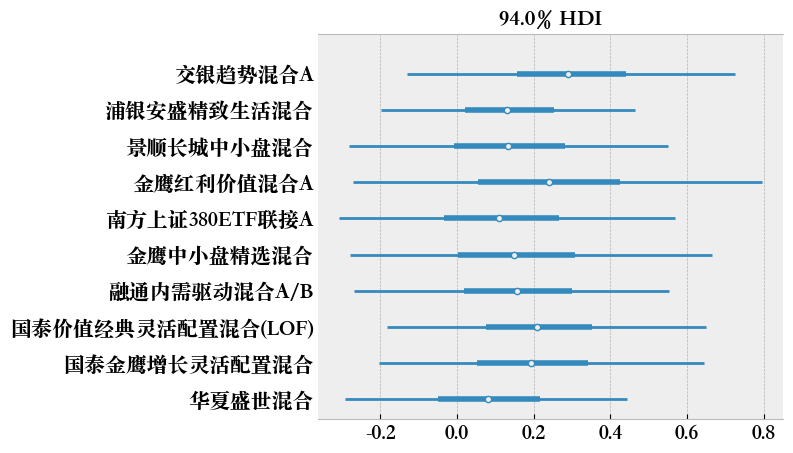

In [122]:
 az.plot_forest(
    trace_alpha_total_dy,
    var_names=["主动基金信息比例IC"],
    #kind="ridgeplot",
    combined=True,
    coords={"Alpha":__Df_alpha_model.index.values},
    labeller=az.labels.NoVarLabeller(),
)
    

In [123]:
#trace_alpha_total_dy.posterior["条件夏普比例预测系数detla:条件夏普自回归项SR"].mean()

# BMA:模型计算

In [124]:
trace_BMA=[trace_alpha_total_dp,
trace_alpha_total_dy,
trace_alpha_total_ep,
trace_alpha_total_de,
trace_alpha_total_svar,
trace_alpha_total_bm,
trace_alpha_total_ntis,
trace_alpha_total_tbl,
trace_alpha_total_ity,
trace_alpha_total_itr,
trace_alpha_total_tms,
trace_alpha_total_dfy,
trace_alpha_total_infl]
model_BMA=[]
for i in Df_macro.index:
    print( "model_total_"+i)
    model_BMA.append("model_total_"+i)

model_total_dp
model_total_dy
model_total_ep
model_total_de
model_total_svar
model_total_bm
model_total_ntis
model_total_tbl
model_total_ity
model_total_itr
model_total_tms
model_total_dfy
model_total_infl


In [125]:
model_dict = dict(zip(model_BMA, trace_BMA))
comp_fund = az.compare(model_dict,ic="loo",method="BB-pseudo-BMA",b_samples=1000,seed=RANDOM_SEED, scale="log",var_name="指数及因子的收益率实现")
comp_alpha = az.compare(model_dict,ic="loo",method="BB-pseudo-BMA",b_samples=1000,seed=RANDOM_SEED, scale="log",var_name="主动基金的收益率实现")

/Users/xinyuexu/opt/anaconda3/envs/FOF02/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/xinyuexu/opt/anaconda3/envs/FOF02/lib/python3.9/site-packages/arviz/stats/stats.py:837: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  warnings.warn(
/Users/xinyuexu/opt/anaconda3/envs/FOF02/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model,

# BMA模型分析:不同模型效力对比及权重计算

In [126]:
import seaborn as sns
cm=sns.color_palette("Spectral", as_cmap=True)
comp_alpha.style.background_gradient(cmap=cm)

In [127]:
comp_fund.style.background_gradient(cmap=cm)

In [128]:
weights_fund = comp_fund.loc[model_BMA]["weight"]


weights_alpha = comp_alpha.loc[model_BMA]["weight"]


#az.summary(trace_alpha_total_ep)

az.summary(trace_alpha_total_dfy, var_names=["宏观因子反应系数:指数及因子条件夏普SR"], round_to=2)
#

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean    sd  hdi_3%  hdi_97%  \
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股(人民币), dp]       -0.03  0.30   -0.44     0.82   
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸低波(人民币), dp]    0.22  0.43   -0.31     1.19   
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸公司质量(人民币), dp] -0.27  0.29   -0.70     0.38   
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸价值(人民币), dp]    0.42  0.51   -0.12     1.56   
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸成长(人民币), dp]    0.11  0.24   -0.28     0.55   
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸中小盘(人民币), dp]   0.34  0.38   -0.15     1.19   
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸动能(人民币), dp]   -0.02  0.35   -0.61     0.81   

                                               mcse_mean  mcse_sd  ess_bulk  \
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股(人民币), dp]             0.03     0.02    141.79   
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸低波(人民币), dp]         0.08     0.06     49.03   
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸公司质量(人民币), dp]       0.02     0.02    287.18   
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸价值(人民币), dp]         0.11     0.08     32.78   
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸成长(人民币), dp]         0.02     0.02    242.37   
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸中小盘(人民币), dp]        0.06     0.05     51.07   
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸动能(人民币), dp]         0.03     0.02    332.31   

                                               ess_tail  r_hat  
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股(人民币), dp]           80.80    NaN  
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸低波(人民币), dp]      110.47    NaN  
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸公司质量(人民币), dp]    133.65    NaN  
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸价值(人民币), dp]       95.26    NaN  
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸成长(人民币), dp]      122.66    NaN  
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸中小盘(人民币), dp]      99.15    NaN  
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸动能(人民币), dp]      161.11    NaN

In [22]:
#az.summary(, var_names=["宏观因子反应系数:指数及因子条件夏普SR"])

In [129]:
data_beta = []

for i in trace_BMA:
    beta = az.summary(i, var_names=["宏观因子反应系数:指数及因子条件夏普SR"], round_to=2)["mean"].values
    data_beta.append(beta)


beta_mean_for_report = pd.DataFrame(data_beta,index=Df_macro.index,columns = Df_Factor.index.values)

beta_mean_for_report.to_excel("宏观因子的检验.xlsx")
data_std = []
for i in trace_BMA:
    beta = az.summary(i, var_names=["宏观因子反应系数:指数及因子条件夏普SR"], round_to=2)["sd"].values
    data_std.append(beta)
beta_std_for_report = pd.DataFrame(data_std,index=Df_macro.index,columns = Df_Factor.index.values)


beta_tscore_for_report=np.abs(beta_mean_for_report/beta_std_for_report)

A=beta_tscore_for_report.style.background_gradient(cmap="Blues").format("{:.2f}", na_rep='MISS')
A.to_excel("宏观因子的统计检验.xlsx")



az.summary(i, var_names=["宏观因子反应系数:指数及因子条件夏普SR"], round_to=2)["mean"]

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股(人民币), dp]          0.36
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸低波(人民币), dp]      0.23
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸公司质量(人民币), dp]   -0.23
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸价值(人民币), dp]      0.08
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸成长(人民币), dp]      0.86
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸中小盘(人民币), dp]     0.38
宏观因子反应系数:指数及因子条件夏普SR[MSCI中国A股在岸动能(人民币), dp]      0.74
Name: mean, dtype: float64

In [130]:
trace_alpha_total_dfy

Inference data with groups:
	> posterior
	> predictions
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

# BMA 模型预测： weight集成:分布收益率与SR（样本外预测分布）

In [131]:
import xarray as xr
def weight_predictions_return(idatas, weights=None):
    """
    Generate weighted posterior predictive samples from a list of InferenceData
    and a set of weights.
    Parameters
    ---------
    idatas : list[InferenceData]
        List of :class:`arviz.InferenceData` objects containing the groups `posterior_predictive`
        and `observed_data`. Observations should be the same for all InferenceData objects.
    weights : array-like, optional
        Individual weights for each model. Weights should be positive. If they do not sum up to 1,
        they will be normalized. Default, same weight for each model.
        Weights can be computed using many different methods including those in
        :func:`arviz.compare`.
    Returns
    -------
    idata: InferenceData
        Output InferenceData object with the groups `posterior_predictive` and `observed_data`.
    See Also
    --------
    compare :  Compare models based on PSIS-LOO `loo` or WAIC `waic` cross-validation
    """
    if len(idatas) < 2:
        raise ValueError("You should provide a list with at least two InferenceData objects")

    if not all("predictions" in idata.groups() for idata in idatas):
        raise ValueError(
            "All the InferenceData objects must contain the `predictions` group"
        )

    if not all(idatas[0].observed_data.equals(idata.observed_data) for idata in idatas[1:]):
        raise ValueError("The observed data should be the same for all InferenceData objects")

    if weights is None:
        weights = np.ones(len(idatas)) / len(idatas)
    elif len(idatas) != len(weights):
        raise ValueError(
            "The number of weights should be the same as the number of InferenceData objects"
        )

    weights = np.array(weights, dtype=float)
    weights /= weights.sum()

    len_idatas = [
        idata.predictions.dims["chain"] * idata.predictions.dims["draw"]
        for idata in idatas
    ]

    if not all(len_idatas):
        raise ValueError("At least one of your idatas has 0 samples")

    new_samples = (np.min(len_idatas) * weights).astype(int)

    new_idatas = [
        az.extract(idata, group="predictions",var_names=["指数及因子的收益率实现","主动基金的收益率实现"], num_samples=samples).reset_coords()
        for samples, idata in zip(new_samples, idatas)
    ]

    
    weighted_samples = az.InferenceData(
        predictions=xr.concat(new_idatas, dim="sample"),
        observed_data=idatas[0].observed_data,
    )

    return weighted_samples

import xarray as xr
def weight_predictions_(idatas, weights=None):
    """
    Generate weighted posterior predictive samples from a list of InferenceData
    and a set of weights.
    Parameters
    ---------
    idatas : list[InferenceData]
        List of :class:`arviz.InferenceData` objects containing the groups `posterior_predictive`
        and `observed_data`. Observations should be the same for all InferenceData objects.
    weights : array-like, optional
        Individual weights for each model. Weights should be positive. If they do not sum up to 1,
        they will be normalized. Default, same weight for each model.
        Weights can be computed using many different methods including those in
        :func:`arviz.compare`.
    Returns
    -------
    idata: InferenceData
        Output InferenceData object with the groups `posterior_predictive` and `observed_data`.
    See Also
    --------
    compare :  Compare models based on PSIS-LOO `loo` or WAIC `waic` cross-validation
    """
    if len(idatas) < 2:
        raise ValueError("You should provide a list with at least two InferenceData objects")

    if not all("predictions" in idata.groups() for idata in idatas):
        raise ValueError(
            "All the InferenceData objects must contain the `predictions` group"
        )

    if not all(idatas[0].observed_data.equals(idata.observed_data) for idata in idatas[1:]):
        raise ValueError("The observed data should be the same for all InferenceData objects")

    if weights is None:
        weights = np.ones(len(idatas)) / len(idatas)
    elif len(idatas) != len(weights):
        raise ValueError(
            "The number of weights should be the same as the number of InferenceData objects"
        )

    weights = np.array(weights, dtype=float)
    weights /= weights.sum()

    len_idatas = [
        idata.predictions.dims["chain"] * idata.predictions.dims["draw"]
        for idata in idatas
    ]

    if not all(len_idatas):
        raise ValueError("At least one of your idatas has 0 samples")

    new_samples = (np.min(len_idatas) * weights).astype(int)

    new_idatas = [
        az.extract(idata, group="predictions",var_names=["条件夏普SR"], num_samples=samples).reset_coords()
        for samples, idata in zip(new_samples, idatas)
    ]

    weighted_samples = az.InferenceData(
        predictions=xr.concat(new_idatas, dim="sample"),
        observed_data=idatas[0].observed_data,
    )

    return weighted_samples

In [132]:
ppc_pred=weight_predictions_(trace_BMA,weights=weights_fund.values)
ppc_pred_r=weight_predictions_return(trace_BMA,weights=weights_fund.values)

In [133]:
from matplotlib.dates import date2num

In [134]:
def regime_switch(betas,threshold=1e-5):
    '''
    Returns a list of starting points of each regime given in input 
    the beta vector as output from a trend-filtering algorithm.
    '''
    n = len(betas)
    init_points = [0]
    curr_reg = (betas[0]>threshold)
    for i in range(n):
        if (betas[i]>threshold) == (not curr_reg):
            curr_reg = not curr_reg
            init_points.append(i)
    init_points.append(n)
    
    return init_points



In [28]:

    
    
    #ax_right.fill_between(TT_figure[T_vol==2],data_fund[Df_Factor.index.values[i]][T_vol==2],1,alpha=0.6)
    

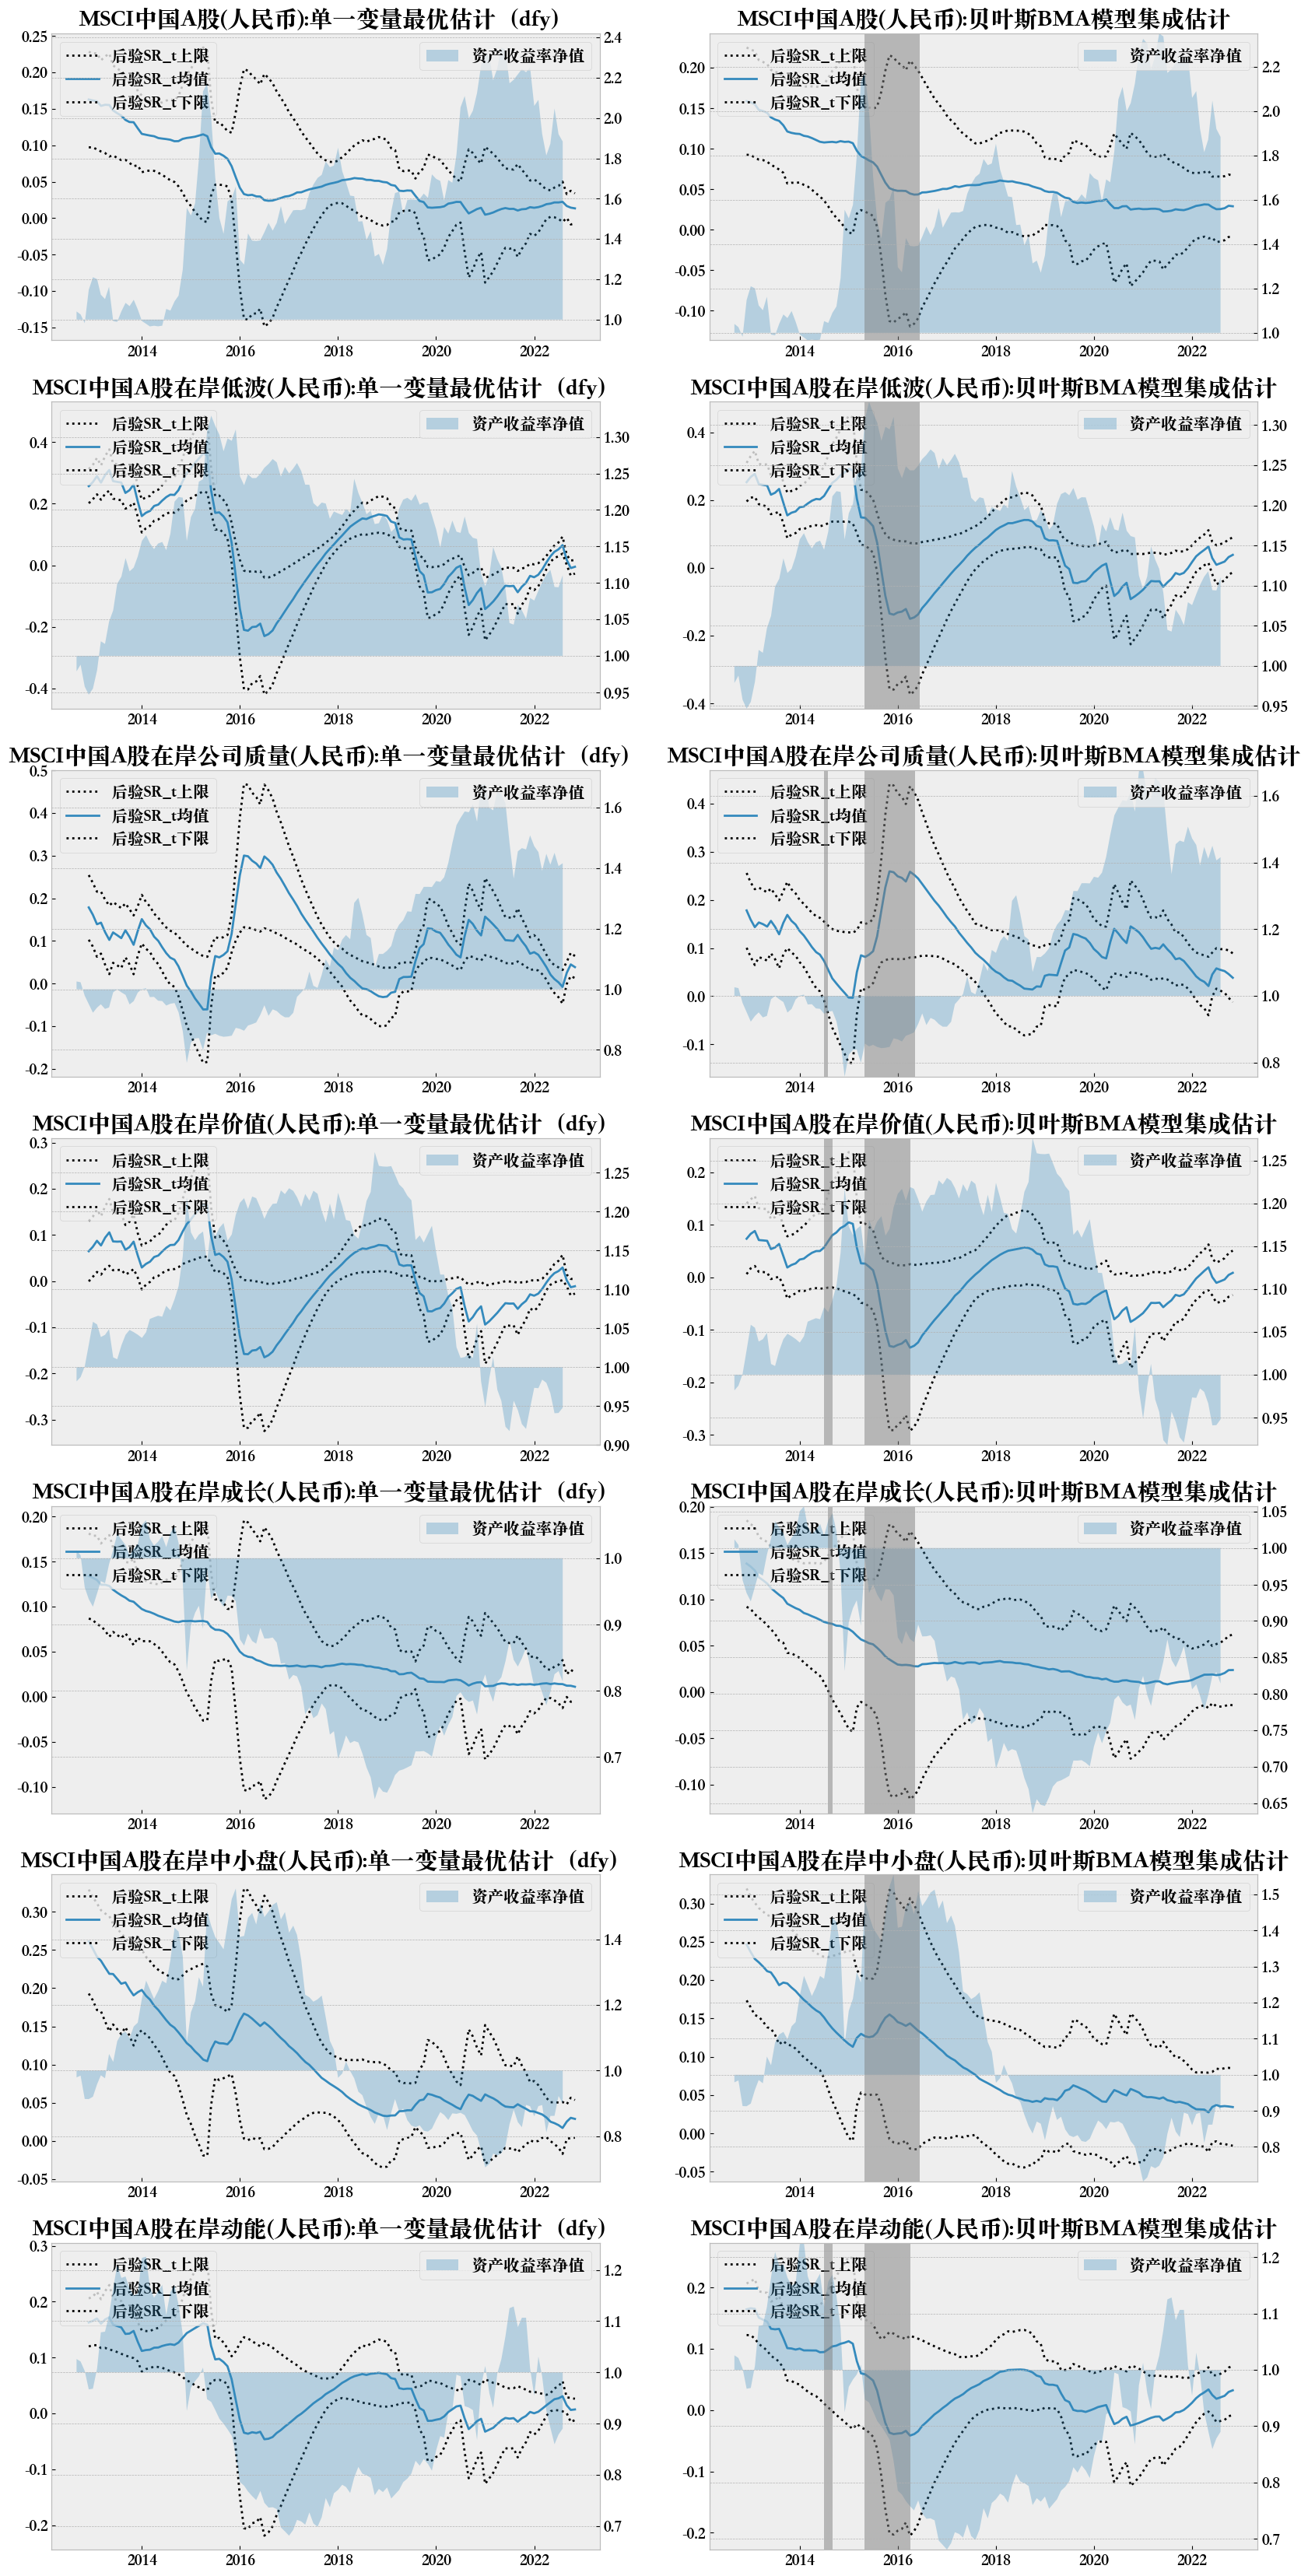

In [136]:
month_interval =(trace_alpha_total_dfy.observed_data.date).astype('datetime64[ns]')[3]-(trace_alpha_total_dy.observed_data.date).astype('datetime64[ns]')[0]

fig,ax =plt.subplots(7,2,figsize=(20,7*6))

SR_t_mean_fig=ppc_pred.predictions.stack()["条件夏普SR"].mean(axis=2)
SR_t_std_fig=ppc_pred.predictions.stack()["条件夏普SR"].std(axis=2)



TT_figure_predict=(ppc_pred.observed_data.date).astype('datetime64[ns]')+month_interval
TT_figure=(ppc_pred.observed_data.date).astype('datetime64[ns]')
data_fund=np.exp((Df_Factor/12).T.cumsum())
for i in range(fund_dim):
  
    idx=SR_t_std_fig[i]>np.quantile(SR_t_std_fig[i],0.95)
   
    
    ax[i,1].plot(TT_figure_predict,SR_t_mean_fig[i]+1*SR_t_std_fig[i],':',color="k",label="后验SR_t上限")
    ax[i,1].plot(TT_figure_predict,SR_t_mean_fig[i],label="后验SR_t均值")
    #ax[i].fill_between(TT_figure_predict,T_vol,0,alpha=0.3,color="r")
    
    ax[i,1].plot(TT_figure_predict,SR_t_mean_fig[i]-1*SR_t_std_fig[i],':',color="k",label="后验SR_t下限")
    
     
    ax[i,1].set_title(Df_Factor.index.values[i]+":贝叶斯BMA模型集成估计")
    ax[i,1].grid()
    #ax[i].set_ylim([-2,2])
    ax[i,1].legend(loc=2)
    ax_right = ax[i,1].twinx()
    
    #__drawdown =(draw_down_price[i] - draw_down_price[i+"_max"])/draw_down_price[i+"_max"]
    #print(__drawdown)
    ax_right.fill_between(TT_figure,data_fund[Df_Factor.index.values[i]],1,alpha=0.3,label="资产收益率净值")
    ax_right.set_ylim([data_fund[Df_Factor.index.values[i]].min(),data_fund[Df_Factor.index.values[i]].max()])
    ax_right.legend(loc=1)
    #x_low=TT_figure[idx]-month_interval/3
    #x_high=TT_figure[idx]+month_interval/3
    
    #(TT_figure[idx][1:].values-TT_figure[idx][:-1].values)/2678400000000000
    
    
    betas =-SR_t_std_fig[i]
    threshold=-np.quantile(SR_t_std_fig[i],0.9)
    regimelist=regime_switch(betas,threshold)
    curr_reg = np.sign(betas[0]-threshold)
    for m in range(len(regimelist)-1):
        if curr_reg == 1:
            pass
            # uncomment below if we want to color the normal regimes
            #ax.axhspan(0, data.max(), xmin=regimelist[i]/regimelist[-1], xmax=regimelist[i+1]/regimelist[-1], 
             #         facecolor="green", alpha=0.3)
        else:
            ax_right.axhspan(0, data_fund[Df_Factor.index.values[i]].max(),  xmin=regimelist[m]/regimelist[-1], xmax=regimelist[m+1]/regimelist[-1], 
                       facecolor='gray', alpha=0.5)
        curr_reg = -1 * curr_reg
        
    
  
    
    
    #ax_right.fill_between(TT_figure[T_vol==2],data_fund[Df_Factor.index.values[i]][T_vol==2],1,alpha=0.6)

#fig,ax =plt.subplots(4,2,figsize=(20,4*6))
#ax=ax.flatten()
SR_t_mean_fig=trace_alpha_total_svar.posterior.stack(pooled_chain=("chain", "draw"))["条件夏普SR"].mean(axis=2)
SR_t_std_fig=trace_alpha_total_svar.posterior.stack(pooled_chain=("chain", "draw"))["条件夏普SR"].std(axis=2)


data_fund=np.exp((Df_Factor/12).T.cumsum())
for i in range(fund_dim):
  
    
    #TT_figure= _xx+T_begin
    
    
    ax[i,0].plot(TT_figure_predict,SR_t_mean_fig[i]+1*SR_t_std_fig[i],':',color="k",label="后验SR_t上限")
    ax[i,0].plot(TT_figure_predict,SR_t_mean_fig[i],label="后验SR_t均值")
    ax[i,0].plot(TT_figure_predict,SR_t_mean_fig[i]-1*SR_t_std_fig[i],':',color="k",label="后验SR_t下限")
    ax[i,0].set_title(Df_Factor.index.values[i]+":单一变量最优估计（dfy）")
    ax[i,0].legend(loc=2)
    ax[i,0].grid()
    
    
    ax_right = ax[i,0].twinx()
    
    #__drawdown =(draw_down_price[i] - draw_down_price[i+"_max"])/draw_down_price[i+"_max"]
    #print(__drawdown)
    ax_right.fill_between(TT_figure,data_fund[Df_Factor.index.values[i]],1,alpha=0.3,label="资产收益率净值")
    ax_right.legend(loc=1)

# BMA模型后验预测：贝叶斯后验分布

In [82]:
ppc_pred_r

Inference data with groups:
	> predictions
	> observed_data

## BMA模型后验预测：贝叶斯后验分布（单一变量）

In [137]:
df_data_r_backtest = pd.DataFrame(columns = ["Period"]).set_index("Period")
df_data_r_backtest.index=pd.date_range(start="2012-09-01",end="2022-09-01",freq="M").to_period("M")
df_data_r_backtest["Test_"] = "True"


In [156]:
###指数与风格的收益率、
data_obs_mean3=az.extract(trace_alpha_total_dfy,group="predictions", var_names="指数及因子的收益率实现", combined=True).mean(axis=2).T.to_dataframe()["指数及因子的收益率实现"].unstack()
data_obs_mean3.index =data_total.columns.to_timestamp().to_period("M")-3

###指数与风格的标准差
data_obs_std3=np.sqrt(12)*(az.extract(trace_alpha_total_dfy,group="predictions", var_names="指数及因子的收益率实现", combined=True)/12).std(axis=2).T.to_dataframe()["指数及因子的收益率实现"].unstack()
data_obs_std3.index =data_total.columns.to_timestamp().to_period("M")-3


###基金的的后验收益率、
data_IC_mean3=az.extract(trace_alpha_total_svar,group="predictions", var_names="主动基金的收益率实现", combined=True).mean(axis=2).T.to_dataframe()["主动基金的收益率实现"].unstack()
data_IC_mean3.index =data_IC_mean3.index.astype('datetime64[ns]').to_period("M")-3

###基金的后验标准差
data_IC_std3=np.sqrt(12)*(az.extract(trace_alpha_total_dfy,group="predictions", var_names="主动基金的收益率实现", combined=True)/12).std(axis=2).T.to_dataframe()["主动基金的收益率实现"].unstack()
data_IC_std3.index =data_IC_std3.index.astype('datetime64[ns]').to_period("M")-3


df_data_r_backtest_mean3 = pd.concat([df_data_r_backtest,data_obs_mean3,data_IC_mean3],axis=1).query('Test_=="True"')
df_data_r_backtest_std3 = pd.concat([df_data_r_backtest,data_obs_std3,data_IC_std3],axis=1).query('Test_=="True"')




df_data_r_backtest_mean3 = df_data_r_backtest_mean3.drop("Test_",axis=1).T
df_data_r_backtest_std3 = df_data_r_backtest_std3.drop("Test_",axis=1).T

## BMA模型后验预测：贝叶斯后验分布（集成变量预测）

In [157]:
###指数与风格的收益率、
data_obs_mean=az.extract(ppc_pred_r,group="predictions", var_names="指数及因子的收益率实现", combined=False).mean(axis=2).T.to_dataframe()["指数及因子的收益率实现"].unstack()
data_obs_mean.index =data_obs_mean.index.astype('datetime64[ns]').to_period("M")-3

###指数与风格的标准差
data_obs_std=np.sqrt(12)*(az.extract(ppc_pred_r,group="predictions", var_names="指数及因子的收益率实现", combined=False)/12).std(axis=2).T.to_dataframe()["指数及因子的收益率实现"].unstack()
data_obs_std.index =data_obs_std.index.astype('datetime64[ns]').to_period("M")-3


###基金的的后验收益率、
data_IC_mean=az.extract(ppc_pred_r,group="predictions", var_names="主动基金的收益率实现", combined=False).mean(axis=2).T.to_dataframe()["主动基金的收益率实现"].unstack()
data_IC_mean.index =data_IC_mean.index.astype('datetime64[ns]').to_period("M")-3

###基金的后验标准差
data_IC_std=np.sqrt(12)*(az.extract(ppc_pred_r,group="predictions", var_names="主动基金的收益率实现", combined=False)/12).std(axis=2).T.to_dataframe()["主动基金的收益率实现"].unstack()
data_IC_std.index =data_IC_std.index.astype('datetime64[ns]').to_period("M")-3


In [140]:



df_data_r_backtest_mean = pd.concat([df_data_r_backtest,data_obs_mean,data_IC_mean],axis=1).query('Test_=="True"')
df_data_r_backtest_std = pd.concat([df_data_r_backtest,data_obs_std,data_IC_std],axis=1).query('Test_=="True"')




df_data_r_backtest_mean2 = df_data_r_backtest_mean.drop("Test_",axis=1).T
df_data_r_backtest_std2 = df_data_r_backtest_std.drop("Test_",axis=1).T

# 配置资产均值方差模块

In [141]:
import sys
sys.path.append("/Users/xinyuexu/Public/multi_asset/编程学习/financial_course/finance-courses")
import edhec_risk_kit_FOF as erk

In [158]:
data_predict_r=pd.concat([Df_Factor,__Df_alpha_model]).T


correlation = pd.concat([Df_Factor,__Df_alpha_model]).T.corr()
correlation.style.background_gradient(cmap=cm).format("{:.2f}", na_rep='MISS')

df_data_r_backtest = pd.DataFrame(columns = ["Period"]).set_index("Period")
df_data_r_backtest.index=pd.date_range(start="2012-09-01",end="2022-09-01",freq="M").to_period("M")
df_data_r_backtest["Test_"] = "True"
index_adj=index_transformer




## 经典收益计算规则

In [159]:
###指数与风格的收益率、方差（滚动36个月回归）
df_ret_ratio_mean_yearly=(index_adj.resample("M").sum()*12).rolling(36).mean()
###波动率计算规则方法1:
#df_ret_ratio_std_yearly=(np.sqrt((index_adj**2).resample("M").sum())*np.sqrt(12)).rolling(36).mean()
###波动率计算规则方法2:
df_ret_ratio_std_yearly=((index_adj.resample("M").sum()*12).rolling(36).std()/np.sqrt(12))


data_alpha_mean_yearly=(data_alpha_filter*12).rolling(36).mean()
data_alpha_std_yearly=(data_alpha_filter*12).rolling(36).std()/np.sqrt(12)






df_data_r_backtest_mean = pd.concat([df_data_r_backtest,df_ret_ratio_mean_yearly,data_alpha_mean_yearly],axis=1).query('Test_=="True"')
df_data_r_backtest_std = pd.concat([df_data_r_backtest,df_ret_ratio_std_yearly,data_alpha_std_yearly],axis=1).query('Test_=="True"')




df_data_r_backtest_mean1 = df_data_r_backtest_mean.drop("Test_",axis=1).T
df_data_r_backtest_std1 = df_data_r_backtest_std.drop("Test_",axis=1).T


index_T = np.arange(len(data_alpha_mean_yearly))
index_mean=df_data_r_backtest_mean1.mean(axis=1)
index_std=df_data_r_backtest_std1.mean(axis=1)
columns_name=df_data_r_backtest_mean1.columns
for i in index_T:
    j = columns_name[i]
    df_data_r_backtest_mean1[j]=index_mean.values
    df_data_r_backtest_std1[j]=index_std.values

/var/folders/bg/h2_d2l2939102wvpkt70y0_00000gn/T/ipykernel_2174/3925281359.py:9: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Test_'], dtype='object')
  data_alpha_mean_yearly=(data_alpha_filter*12).rolling(36).mean()
/var/folders/bg/h2_d2l2939102wvpkt70y0_00000gn/T/ipykernel_2174/3925281359.py:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Test_'], dtype='object')
  data_alpha_std_yearly=(data_alpha_filter*12).rolling(36).std()/np.sqrt(12)


## 贝叶斯后验的均值和方差

In [160]:

def weight_minvar(ret,cov):
    '''
    Produces the weights of the Minimum Volatility Portfolio given a covariance matrix of the returns 
    '''
    return erk.minimize_volatility(ret, cov)

def weight_maxsharpe(ret,cov, periods_per_year=1, risk_free_rate=0):
    '''
    Produces the weights of the Maximum Sharpe Ratio Portfolio given a covariance matrix of the returns 
    '''
    est_cov = cov
   
    ann_ret=np.squeeze(ret)
    return erk.maximize_shape_ratio_robust(ann_ret, est_cov, risk_free_rate=risk_free_rate, periods_per_year=periods_per_year)



def weight_ew(ret,cov, cap_ws=None, max_cw_mult=None, microcap_thr=None, **kwargs):
    """
    Returns the weights of the Equally-Weighted (EW) portfolio based on the asset returns "r" as a DataFrame. 
    If the set of cap_ws is given, the modified scheme is computed, i.e., 
    microcaps are removed and a capweight tether applied.
    """
    r =ret.T
    ew = pd.Series(1/len(r.columns), index=r.columns)
    if cap_ws is not None:
        cw = cap_ws.loc[r.index[0]] # starting cap weight
        if microcap_thr is not None and microcap_thr > 0.0:
            # exclude microcaps according to the threshold    
            ew[ cw < microcap_thr ] = 0
            ew = ew / ew.sum()
        if max_cw_mult is not None and max_cw_mult > 0:
            # limit weight up to a multiple of capweight
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew / ew.sum()
    return ew







def backtest_weight_scheme(r,Ret,Std,window=36,weight_scheme=weight_ew, **kwargs):
    '''
    Backtests a given weighting scheme. Here:
    - r: asset returns to use to build the portfolio
    - window: the rolling window used
    - weight_scheme: the weighting scheme to use, it must the name of a 
    method that takes "r", and a variable number of keyword-value arguments
    '''
    n_periods = r.shape[0]
    windows = [ (start, start+window) for start in range(0,n_periods-window) ]
    weights=[]
    
    
    for win in windows: 
        
        index=win[1]
        ret =Ret.iloc[[index]].T
        ret_sd = np.expand_dims(Std.iloc[index].values, axis=1)  
        cov = ret_sd.dot(ret_sd.T)*correlation  
        weight = weight_scheme(ret,cov,**kwargs)
        weights.append(weight)
        
    weights = pd.DataFrame(weights, index=r.iloc[window:].index, columns=r.columns)    
    returns = (weights * r).sum(axis=1,  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return weights,returns

In [161]:
Ret2 = df_data_r_backtest_mean2.T
Ret1 = df_data_r_backtest_mean1.T

# 策略权重

In [162]:
weight_ALL={}

r_ALL={}

Ret = df_data_r_backtest_mean1.T
Std = df_data_r_backtest_std1.T

#weights,returns = backtest_weight_scheme(data_predict_r,Ret,Std,window=36, weight_scheme=weight_minvar)
#weight_ALL["最小方差:传统滚动36个月分布"]= weights
#r_ALL["最小方差:传统滚动36个月分布"]= returns


weights,returns = backtest_weight_scheme(data_predict_r,Ret,Std,window=36, weight_scheme=weight_maxsharpe)
weight_ALL["最大夏普MV模型:样本均值方差"]= weights
r_ALL["最大夏普MV模型:样本均值方差"]= returns


Ret3 = df_data_r_backtest_mean3.T
Std3 = df_data_r_backtest_std3.T
weights,returns = backtest_weight_scheme(data_predict_r,Ret3,Std3,window=36, weight_scheme=weight_maxsharpe)
weight_ALL["最大夏普MV模型:贝叶斯后验：最优宏观变量svar"]= weights
r_ALL["最大夏普MV模型:贝叶斯后验:最优宏观变量svar"]= returns







Ret2 = df_data_r_backtest_mean2.T
Std2 = df_data_r_backtest_std2.T


weights,returns = backtest_weight_scheme(data_predict_r,Ret2,Std2,window=36, weight_scheme=weight_maxsharpe)
weight_ALL["最大夏普MV模型:贝叶斯后验BMA"]= weights
r_ALL["最大夏普MV模型:贝叶斯后验分布BMA"]= returns
weights,returns = backtest_weight_scheme(data_predict_r,Ret,Std,window=36, weight_scheme=weight_ew)
#weight_ALL["等权重"]= weights
#r_ALL["等权重"]= returns
#weights,returns = backtest_weight_scheme(data_predict_r,Ret,Std,window=36, weight_scheme=weight_minvar)
#weight_ALL["最小方差:贝叶斯后验"]= weights
#r_ALL["最小方差:贝叶斯后验分布"]= returns


#weights,returns = backtest_weight_scheme(data_predict_r,Ret,Std,window=36, weight_scheme=weight_minvar)
#weight_ALL["最小方差:传统滚动36个月分布"]= weights
#r_ALL["最小方差:传统滚动36个月分布"]= returns



#weights.mean(axis=0).plot.bar()
#np.exp(returns.cumsum()/12).plot()

df_Wight_all =pd.concat(weight_ALL).groupby(level=0).mean()





# 配置权重分析

In [163]:
weight_all_mean = {}
for i in weight_ALL.keys():
    weight_all_mean[i]= weight_ALL[i].mean(axis=0)

weight_all_mean=pd.DataFrame(weight_all_mean).T

#weight_all_mean=weight_all_mean.iloc[[2,0,1]]

cm_=sns.color_palette("Spectral",17)
#pd.DataFrame(weight_ALL).T.plot.bar(grid=True, figsize=(20,5),rot=45)



fig,ax =plt.subplots(figsize=(20,10))
x= np.zeros_like(weight_all_mean["MSCI中国A股(人民币)"].values)

for j,i in enumerate(weight_all_mean.columns):
   
    #print(i)
   
    ax.bar(weight_all_mean.index,weight_all_mean[i].values,bottom=x,width=0.15,label=i)
    x= x+weight_all_mean[i].values
ax.set_ylabel("权重")
ax.set_title("平均配置占比")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))



In [164]:
np.exp(pd.concat(r_ALL,axis=1).dropna().cumsum()/12).plot()

<AxesSubplot: >

In [165]:
pd.concat(r_ALL,axis=1).dropna().dropna()

最大夏普MV模型:样本均值方差  最大夏普MV模型:贝叶斯后验:最优宏观变量dfy  最大夏普MV模型:贝叶斯后验分布BMA
2015-09         0.035845                  0.058329             0.036439
2015-10         0.137939                  0.089635             0.851221
2015-11         0.191328                  0.298216             0.303282
2015-12         0.325172                  0.269889             0.344662
2016-01        -0.326803                 -0.865856            -1.010303
...                  ...                       ...                  ...
2022-04        -0.083215                 -0.267635            -0.401543
2022-05         0.007122                  0.413275             0.016671
2022-06         0.124744                  0.735557             0.735557
2022-07        -0.088490                  0.037498             0.037498
2022-08         0.024962                 -0.270451            -0.270451

[84 rows x 3 columns]

# 配置策略分析：总体指标分析

In [166]:
table =erk.summary_stats(pd.concat(r_ALL,axis=1).dropna()/12,risk_free_rate=0,periods_per_year=12, var_level=0.05).style.format("{:.3f}", na_rep='MISS')

In [152]:
table

In [ ]:
table.to_excel("FOF_backtesting_result.xlsx")

# 配置策略分析：

In [153]:


def decompose_r_static_dynamic(weight_i,r_i):
    r = weight_i*r_i_compose_
    r_total = r.sum(axis=1)
    r_Total = r_total.mean()
    
    r_static = weight_i.mean(axis=0)*r_i_compose_.mean(axis=0)
    r_static_Total = r_static.sum()
    
    COV=0
    for i in weight_i_compose.columns:
        cov=np.cov(weight_i_compose[i],r_i_compose_[i],ddof=0)[1,0]
        COV=COV+cov
    r_dynamic_Total =COV
    
    return r_Total,r_static_Total,r_dynamic_Total
    

In [154]:
performance_attribution={}

for i in weight_ALL.keys():

    weight_i_compose=weight_ALL[i]
    r_i_compose_=data_predict_r.loc[weight_i_compose.index]
    r,r_static,r_dynamic=decompose_r_static_dynamic(weight_i_compose,r_i_compose_)
    performance_attribution[i] = [r,r_static,r_dynamic]

PA = pd.DataFrame.from_dict(performance_attribution)

PA.index =["总收益","配置收益","择时收益"]

In [155]:
PA

最大夏普MV模型:样本均值方差  最大夏普MV模型:贝叶斯后验：最优宏观变量dfy  最大夏普MV模型:贝叶斯后验BMA
总收益      3.056875e-02                  0.103751           0.100350
配置收益     3.056875e-02                  0.097164           0.081084
择时收益     5.877002e-34                  0.006587           0.019267